# Gaussian Process for Binary classification (with Laplace Approximation)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

## Generate synthetic data

In [9]:
# Define the number of each mixture
number_class_1 = 50
number_class_2 = 50

# Define the mean of each mixture
mean_1 = np.array([0, 0])
mean_2 = np.array([5, 0])

# Define the covariance of each mixture
sigma = 0.8
cov_1 = np.eye(2) * sigma
cov_2 = np.eye(2) * sigma

# Generate clusters
cluster_1 = np.random.multivariate_normal(mean=mean_1, cov=cov_1, size=number_class_1)
cluster_2 = np.random.multivariate_normal(mean=mean_2, cov=cov_2, size=number_class_2)

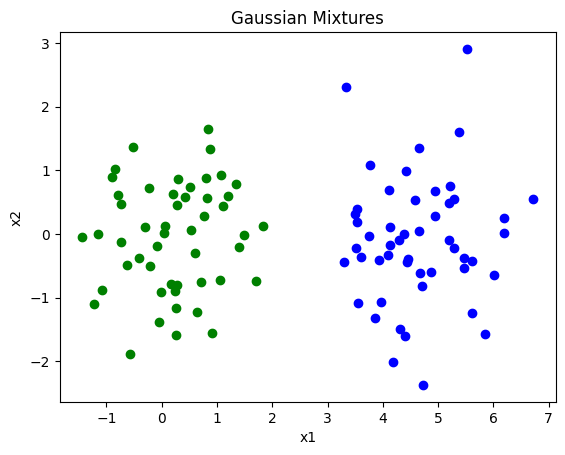

In [12]:
# Plot data
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], color='green')
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], color='blue')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Gaussian Mixtures')
plt.show()

In [17]:
# Create a dataset
X_1 = np.hstack((np.ones(cluster_1.shape[0]).reshape(-1, 1), cluster_1))
X_2 = np.hstack((np.ones(cluster_2.shape[0]).reshape(-1, 1), cluster_2))

# Merge the train features
X = np.vstack((X_1, X_2))
t = np.array([0] * number_class_1 + [1] * number_class_2)

## Implementing Gaussian Process for classification 

In [51]:
def sigmoid(a):
    """
    Define sigmoid function
    :param a: input to sigmoid function
    :return: value of sigmoid function
    """
    return 1 / (1 + np.exp(-a))

def find_posterior_mean(X, t, nu, gamma, learning_rate, epochs):
    """
    Find the mode of the distribution p(a_N | t_N)
    :param X: train features
    :param t: train labels
    :param nu: added term to C, the covariance matrix
    :param gamma: the parameter of RBF kernel function
    :param learning_rate: learning rate of Newton's method
    :param epochs: the epochs to update the mode in Newton's method
    :return: the mode of the posterior distribution
    """
    # Get the dimension
    N = X.shape[0]
    
    # Calculate the covariance matrix C_N
    C_N = rbf_kernel(X, gamma=gamma) + nu * np.eye(N)
    
    # Find the eigenvalues and eigenvectors of C_N
    eigenvalues, _ = np.linalg.eig(C_N)
    
    # Initialise random mode
    mode = np.random.uniform(size=N)
    
    # Use Newton-Raphson method to iterative update the mode
    costs = []
    for epoch in range(epochs):
        # Update the mode
        sigma_N = sigmoid(mode)
        W_N = np.diag(sigma_N * (1 - sigma_N))
        mode_new = C_N @ np.linalg.solve(np.eye(N) + W_N @ C_N, t - sigma_N + W_N @ mode)
        
        # Update the mode
        mode = mode + learning_rate * (mode_new - mode)

        # Calculate the cost
        cost = (-0.5 * np.dot(mode, np.linalg.solve(C_N, mode)) - 0.5 * np.sum(np.log(eigenvalues)) 
                + np.dot(t, mode)) - np.sum(np.log(1 + np.exp(mode)))
        
        # Append the cost and display
        print(f"EPOCHS: {epoch} - Cost: {cost}")
        costs.append(cost)
        
    return mode, costs
    
    
def find_posterior_covariance(X, t, mode, nu, gamma):
    """
    Find the covariance matrix of the distribution p(a_N | t_N)
    :param X: train features
    :param t: train labels
    :param mode: mode of the distribution
    :param nu: added term to C, the covariance matrix
    :param gamma: the parameter of RBF kernel function
    :return: the covariance matrix of the distribution
    """
    # Get the dimension
    N = X.shape[0]
    
    # Calculate the covariance matrix C_N
    C_N = rbf_kernel(X, gamma=gamma) + nu * np.eye(N)
    
    # Calculate W_N
    sigma_N = sigmoid(mode)
    W_N = np.diag(sigma_N * (1 - sigma_N))
    
    # Calculate the Hessian
    H = W_N + np.linalg.inv(C_N)
    return np.linalg.inv(H)


def prediction_function(X_test, X_train, t, mode, nu, gamma):
    """
    Predict p(t_{N+1} | t_N)
    :param X_test: the test points
    :param X_train: the train features
    :param t: the train labels
    :param mode: the mode of p(a_{N+1} | t_N)
    :param gamma: the parameter of RBF kernel function
    :param nu: additive term to the covariance matrix C_N
    :return: the prediction
    """
    # Get the dimension
    N = X_train.shape[0]
    
    # Calculate the covariance matrix C_N
    C_N = rbf_kernel(X_train, gamma=gamma) + nu * np.eye(N)
    
    # Calculate the matrix W_N
    sigma_N = sigmoid(mode)
    W_N = np.diag(sigma_N * (1 - sigma_N))
    W_N_inv = np.linalg.inv(W_N)
    
    # Calculate the prediction
    predictions = []
    for x_test in X_test:
        # Calculate k
        k = rbf_kernel(X, x_test.reshape(1, -1), gamma=gamma).reshape(-1)
        
        # Calculate the mean and variance
        mean = np.dot(k, t - sigma_N)
        var = (rbf_kernel(x_test.reshape(1, -1), x_test.reshape(1, -1))[0][0] 
               - np.dot(k, np.linalg.solve(W_N_inv + C_N, k)))
        
        # Calculate the prediction
        prediction = sigmoid(mean / np.sqrt(1 + np.pi * var / 8))
        predictions.append(prediction)
        
    return np.array(predictions)

In [52]:
# Find the mode
mode, costs = find_posterior_mean(X, t, nu=0.01, gamma=0.5, learning_rate=0.1, epochs=100)
covariance = find_posterior_covariance(X, t, mode=mode, nu=0.01, gamma=0.5)

# Calculate the prediction
predictions = prediction_function(X_test=X, X_train=X, t=t, mode=mode, nu=0.01, gamma=0.5)

EPOCHS: 0 - Cost: -83.49083860943225
EPOCHS: 1 - Cost: -44.30061650021891
EPOCHS: 2 - Cost: -12.612029199462128
EPOCHS: 3 - Cost: 13.08263831475324
EPOCHS: 4 - Cost: 33.95949022836464
EPOCHS: 5 - Cost: 50.94783670023358
EPOCHS: 6 - Cost: 64.78821307505783
EPOCHS: 7 - Cost: 76.07422099775125
EPOCHS: 8 - Cost: 85.28375215953207
EPOCHS: 9 - Cost: 92.8028262337326
EPOCHS: 10 - Cost: 98.94407765979756
EPOCHS: 11 - Cost: 103.96125275111129
EPOCHS: 12 - Cost: 108.06067087970716
EPOCHS: 13 - Cost: 111.4103412083391
EPOCHS: 14 - Cost: 114.14724931037154
EPOCHS: 15 - Cost: 116.38320364985829
EPOCHS: 16 - Cost: 118.20954183615167
EPOCHS: 17 - Cost: 119.70092975671722
EPOCHS: 18 - Cost: 120.9184361918212
EPOCHS: 19 - Cost: 121.91202679921498
EPOCHS: 20 - Cost: 122.72259136443144
EPOCHS: 21 - Cost: 123.38359480281987
EPOCHS: 22 - Cost: 123.9224240315787
EPOCHS: 23 - Cost: 124.36148836395068
EPOCHS: 24 - Cost: 124.71911965203981
EPOCHS: 25 - Cost: 125.01030935782074
EPOCHS: 26 - Cost: 125.2473125502

In [55]:
# Calculate the accuracy of Gaussian Processes for classification
accuracy = np.sum((predictions >= 0.5) == t) / predictions.shape[0]
print(f"Accuracy of Gaussian Process for classification: {accuracy}")

Accuracy of Gaussian Process for classification: 1.0
